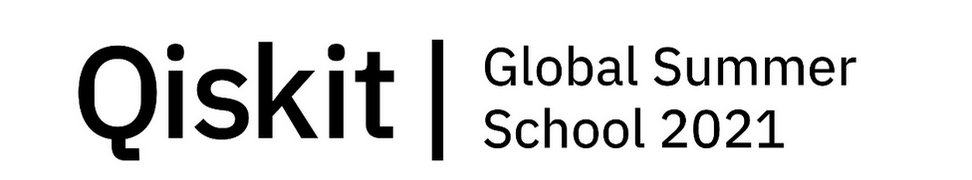

# パラメーター化量子回路の学習

このラボセッションでは、回路ベースのモデルをトレーニングする方法について詳しく見ていきます。このセッションの終わりには、以下のことがわかるはずです。

* 変分法量子分類器の作り方
* さまざまな学習手法、特に勾配ベースの学習手法の使い方
* 変分法に基づくモデルにはどのような制限があり、それをどのように克服できるか


## どこでパラメーター化回路を学習する必要があるか？

<div>
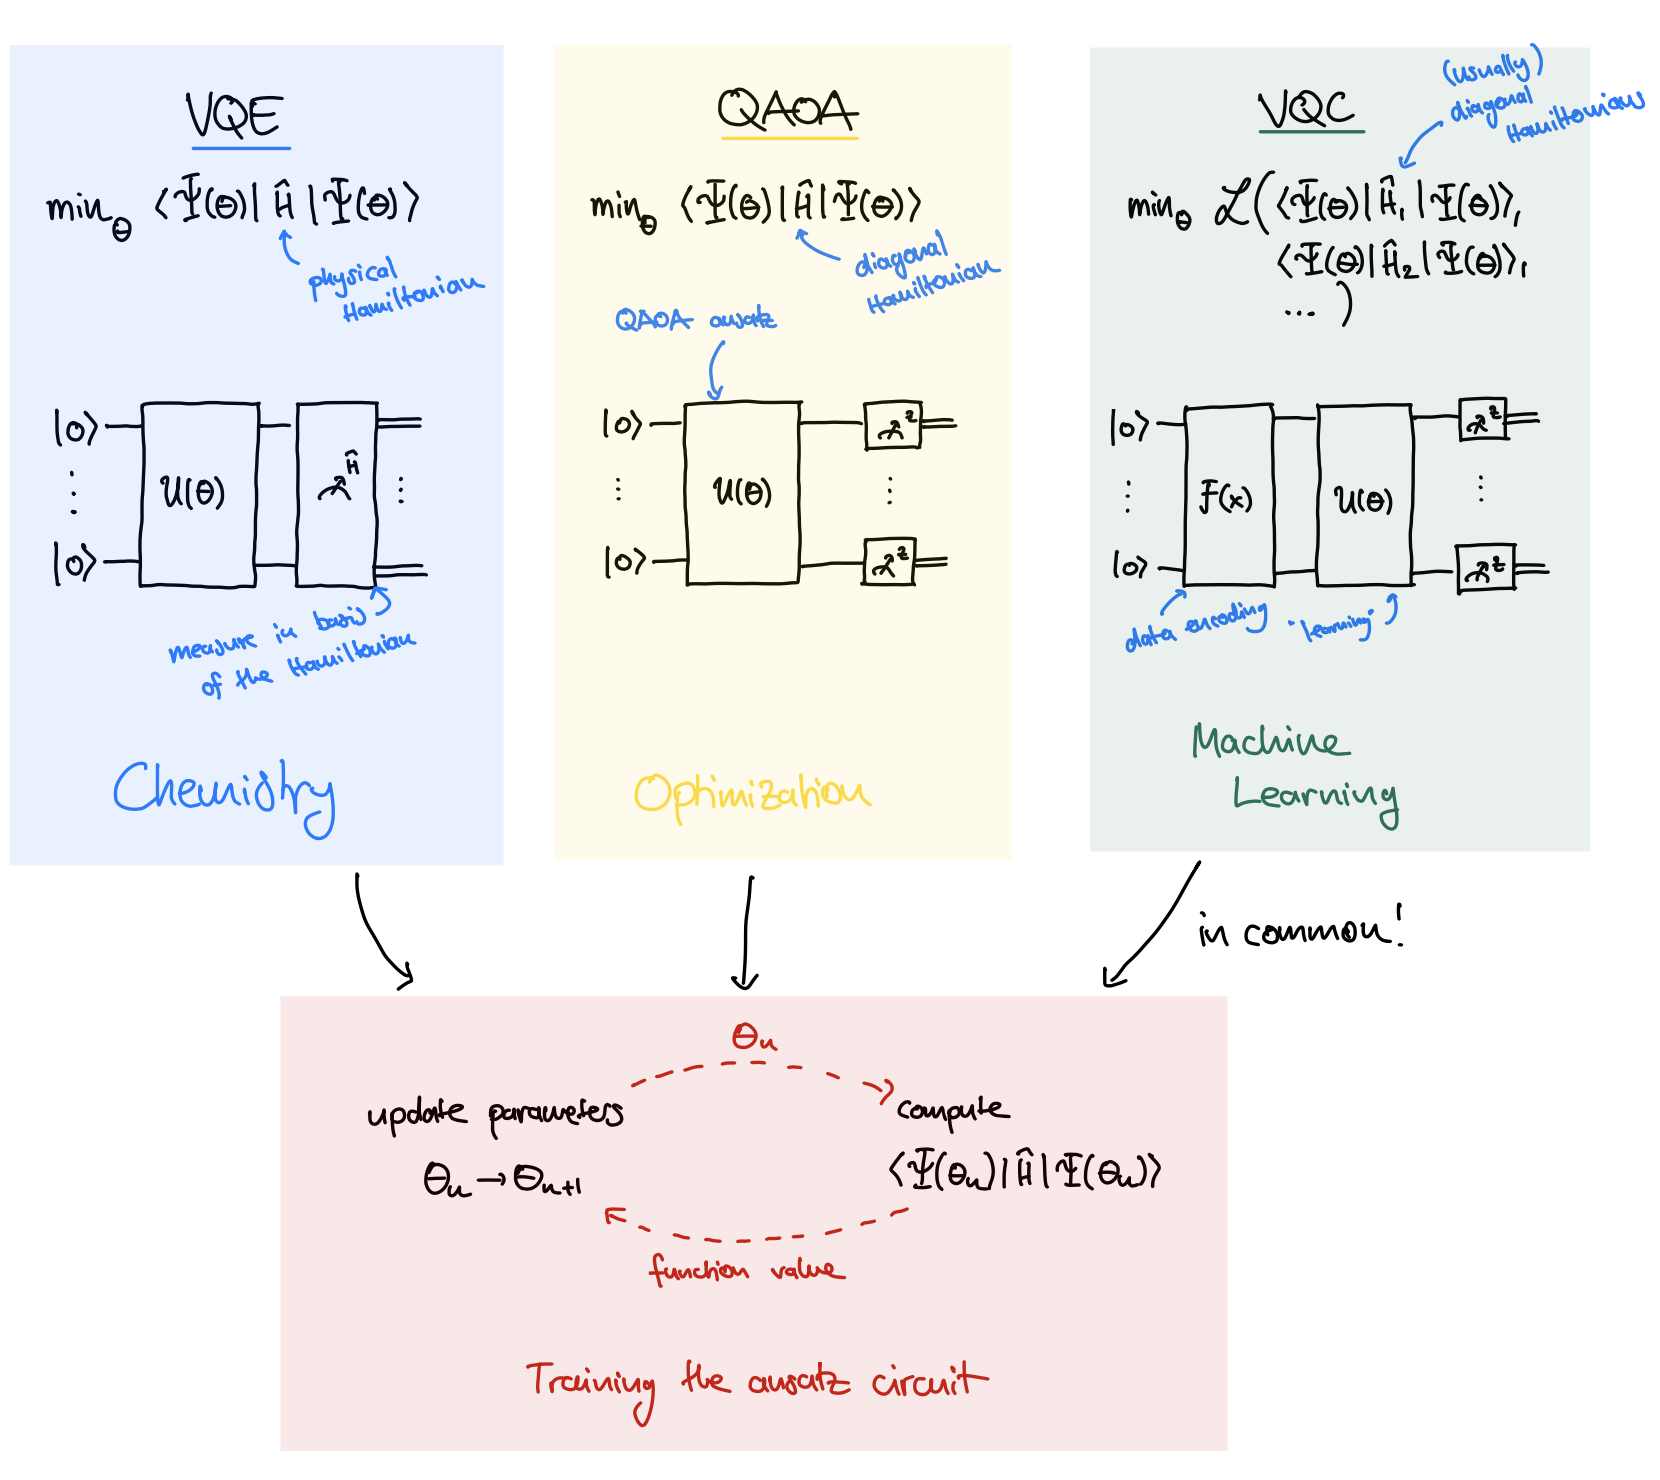
</div>

## タスク

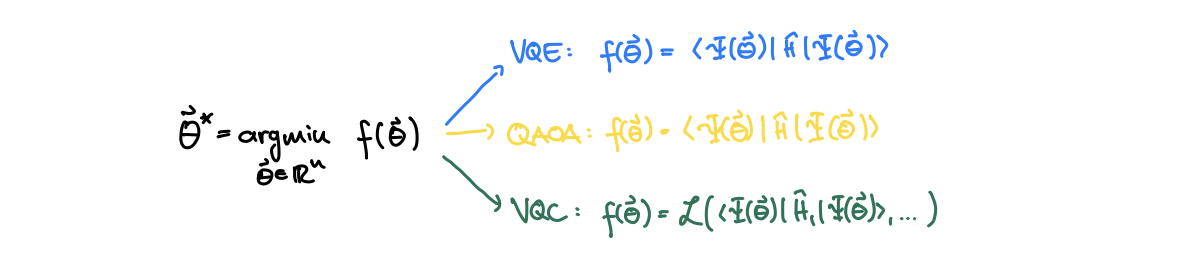

## 勾配

<div>
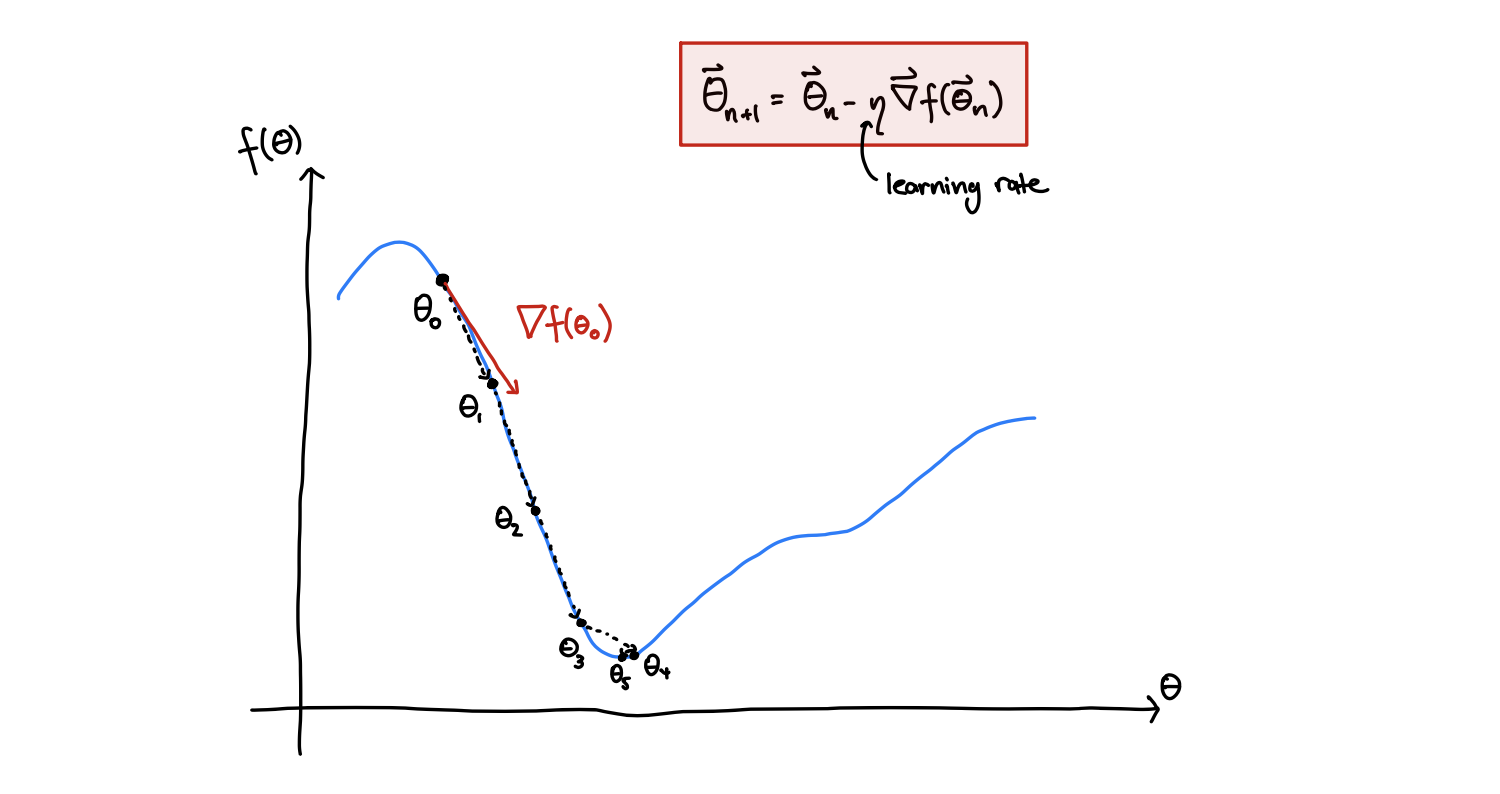
</div>

Qiskitでは期待値の勾配を計算する方法をいくつか提供しています。それらを見ていきましょう！

パラメーター化試行状態（Ansatz）は $|\Psi(\vec\theta)\rangle = U(\vec\theta)|0\rangle$ です。ここで $U(\vec\theta)$は次の回路で与えられます。

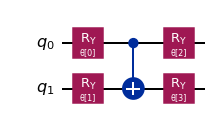

In [2]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=2, reps=1, entanglement='linear')
ansatz.draw('mpl', style='iqx')

そして、この例での我々のハミルトニアンは$\hat H = \hat Z \bigotimes \hat Z$です。

In [3]:
from qiskit.opflow import Z, I

hamiltonian = Z ^ Z

これらを使って期待値を計算します。 $\langle\Psi(\vec\theta) | \hat H | \Psi(\vec\theta)\rangle$:

In [4]:
from qiskit.opflow import StateFn

expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)

具体的には 、$\vec p$と添字$i$を固定した上で次のことを考えます:「点 $\vec p$ でのパラメータ $\theta_i$ に対する期待値の微分は何か？」

$$
    \frac{\partial}{\partial \theta_i} \langle \Psi(\vec\theta) | \hat H | \Psi(\vec\theta) \rangle \bigg\vert_{\vec\theta = \vec p}
$$

ランダムな点$\vec p$と添字$i=2$を選びます。（0からカウントすることを忘れないでください）

In [5]:
import numpy as np

point = np.random.random(ansatz.num_parameters)
index = 2

このセッションを通して、8192ショットのショットベースシミュレーターを使っていきます。

In [6]:
from qiskit import Aer
from qiskit.utils import QuantumInstance

backend = Aer.get_backend('qasm_simulator')
q_instance = QuantumInstance(backend, shots = 8192, seed_simulator = 2718, seed_transpiler = 2718)

**_期待値の計算_**


_期待値を使うことが多いので、Qiskitでどのように使われていたかを振り返ってみましょう。_

_``qiskit.opflow`` モジュールを使って、期待値を書いたり評価することができます。ある回路によって準備された状態の期待値の一般的な構造は次のようになります。_

    expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(circuit)
    result = expectation.eval()
    
_上記のコードでは、期待値の評価に単純な行列の乗算を使用していますが、これは量子ビットの数が多い場合には非効率的です。 代わりに、シミュレーター (もしくは実量子デバイス)を使って、``CircuitSampler`` と ``PauliExpectation`` のような期待値変換器を併用して、以下のように回路を評価することができます。_

    sampler = CircuitSampler(q_instance)  # q_instanceはノートブックの最初で定義したQuantumInstanceです。
    expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(circuit)
    in_pauli_basis = PauliExpectation().convert(expectation)
    result = sampler.convert(in_pauli_basis).eval()

_Exercise 1:次のハミルトニアン``H``と単純な行列積回路``U`` で準備される状態との期待を計算してみましょう。_

In [ ]:
from qiskit.circuit import QuantumCircuit
from qiskit.opflow import Z, X

H = X ^ X

U = QuantumCircuit(2)
U.h(0)
U.cx(0, 1)

# ここにコードを書いてください

In [ ]:
from qc_grader import grade_lab4_ex1

# grade関数は複素数を期待していることに注意してください
grade_lab4_ex1(matmult_result)

_Exercise 2: ノートブックの最初に定義した``QuantumInstance``オブジェクト``q_instance`` を使ってQASMシミュレーターでの期待値を評価してみましょう。_

In [ ]:
from qiskit.opflow import CircuitSampler, PauliExpectation

sampler = CircuitSampler(q_instance)

# ここにコードを書いてください

In [ ]:
from qc_grader import grade_lab4_ex2

# grade関数は複素数を期待していることに注意してください
grade_lab4_ex2(shots_result)

### 有限差分勾配

勾配を近似する最も簡単な方法は、おそらく有限差分法です。これは、関数の内部構造（非常に複雑な場合もある）に関係なく動作します。

<div>
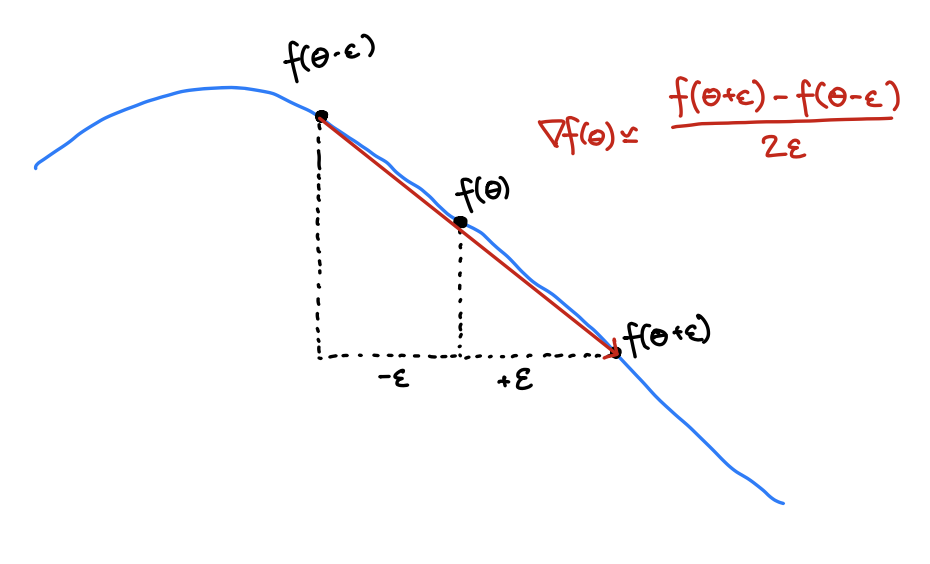
</div>

In [7]:
from qiskit.opflow import PauliExpectation, CircuitSampler

expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
in_pauli_basis = PauliExpectation().convert(expectation)
sampler = CircuitSampler(q_instance)

def evaluate_expectation(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(in_pauli_basis, params=value_dict).eval()  
    return np.real(result)

In [8]:
eps = 0.2
e_i = np.identity(point.size)[:, index]  # 単位ベクトルのときは"index"が1、それ以外の場合は0

plus = point + eps * e_i
minus = point - eps * e_i

In [9]:
finite_difference = (evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * eps)

print(finite_difference)

-0.3314208984375003


手作りでこの計算をする代わりに、Qiskitの``Gradient``クラスをこのために使うことができます。

In [10]:
from qiskit.opflow import Gradient

expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
shifter = Gradient('fin_diff', analytic=False, epsilon=eps)
grad = shifter.convert(expectation, params=ansatz.parameters[index])
print(grad)

SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ RY(θ[0]) ├──■──┤ RY(θ[2] + 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ RY(θ[1]) ├┤ X ├───┤ RY(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ RY(θ[0]) ├──■──┤ RY(θ[2] - 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ RY(θ[1]) ├┤ X ├───┤ RY(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ])
])


In [11]:
value_dict = dict(zip(ansatz.parameters, point))
sampler.convert(grad, value_dict).eval().real

-0.357666015625

有限差分勾配はノイズの多い関数では不安定になることがあり、勾配の正確な公式を使うことでより安定した結果を得ることができます。

<div>
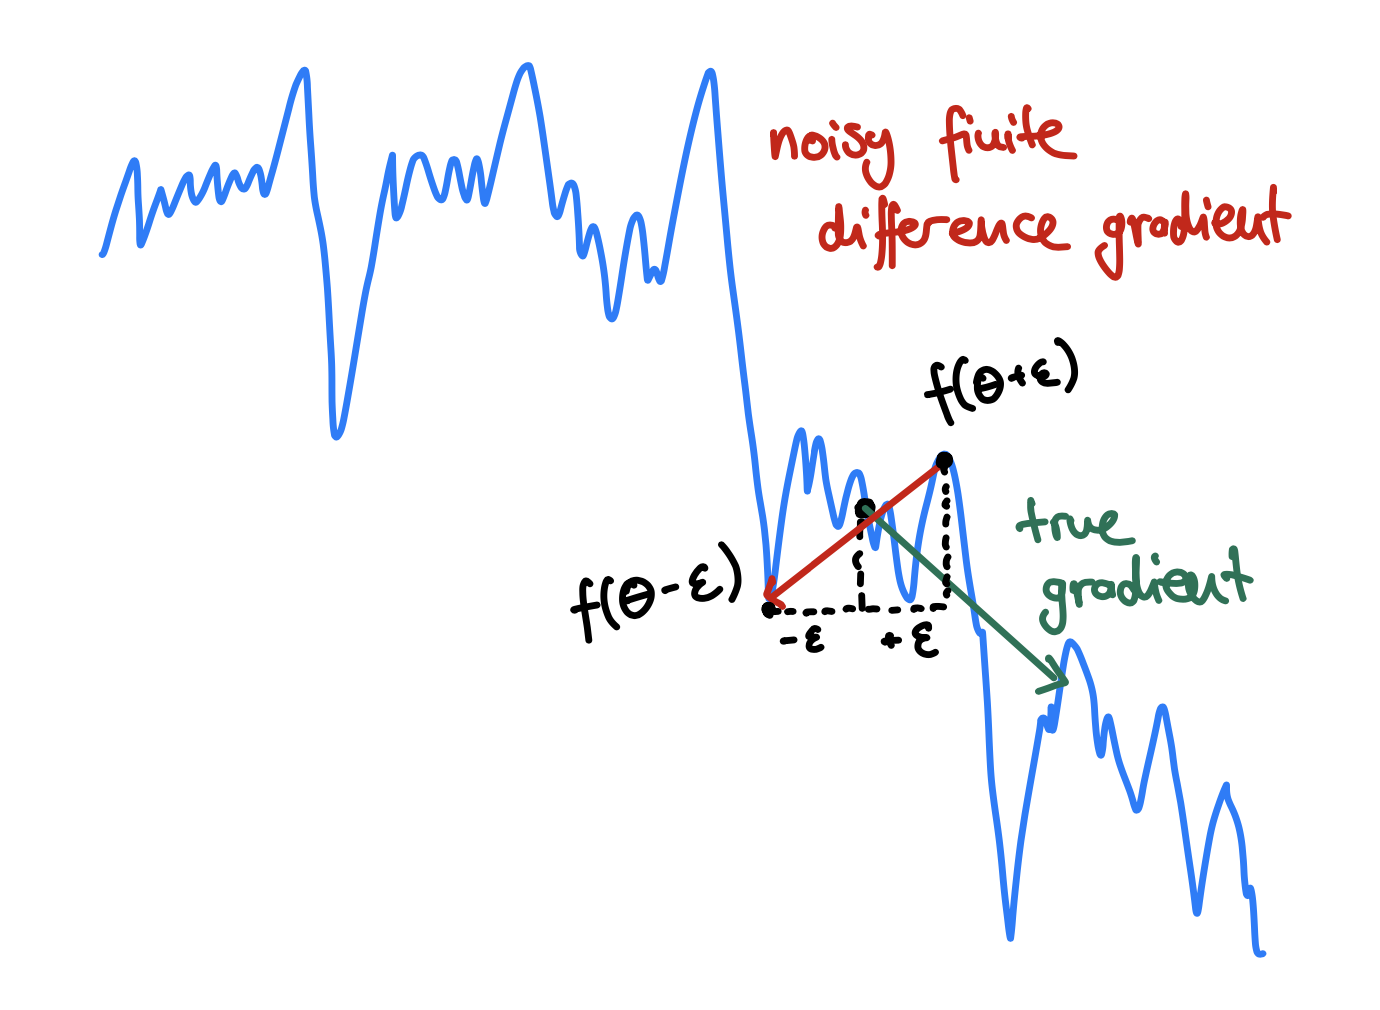
</div>

### 解析的勾配

幸運なことに、回路ベース勾配の公式として、パラメーターシフト則（_parameter shift_ rule）というものがあります. (**注意:** ここでは、係数のないPauli回転についてのみ述べます,  [Evaluating analytic gradients on quantum hardware](https://arxiv.org/abs/1811.11184))を参照してください。

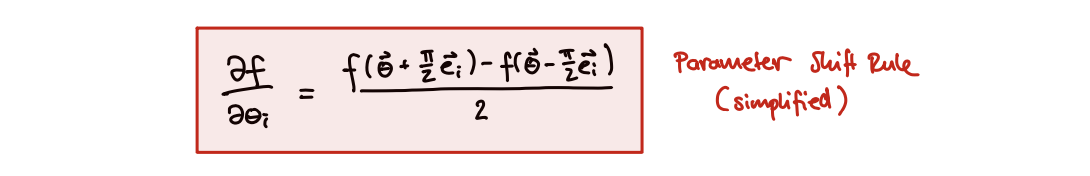

In [12]:
eps = np.pi / 2
e_i = np.identity(point.size)[:, index]  # identity vector with a 1 at index ``index``, otherwise 0

plus = point + eps * e_i
minus = point - eps * e_i

finite_difference = (evaluate_expectation(plus) - evaluate_expectation(minus)) / 2

print(finite_difference)

-0.3402099609375


In [13]:
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
shifter = Gradient()  # パラメーターシフト則がデフォルトです
grad = shifter.convert(expectation, params=ansatz.parameters[index])
sampler.convert(grad, value_dict).eval().real

-0.35070800781249994

同じ原理で、_ユニタリ線形結合（linear combination of unitaries)_ アプローチというものがあります。追加の補助量子ビットを使いますが、１つの回路だけを使うことができます。

In [14]:
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
shifter = Gradient('lin_comb')  # parameter-shift rule is the default
grad = shifter.convert(expectation, params=ansatz.parameters[index])
sampler.convert(grad, value_dict).eval().real

-0.3559570312500001

最適化を試してみましょう！

再現性を高めるために、最初のポイントを固定しました。

In [15]:
# initial_point = np.random.random(ansatz.num_parameters)
initial_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])

期待値を評価する関数があるのと同様に、勾配を評価する関数も必要です。

In [16]:
expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(ansatz))  
gradient = Gradient().convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(q_instance)

def evaluate_gradient(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(gradient_in_pauli_basis, params=value_dict).eval()  # add parameters in here!
    return np.real(result)    

オプティマイザーの収束を比較するために、コールバック関数を使って各ステップでの損失を追跡することができます。

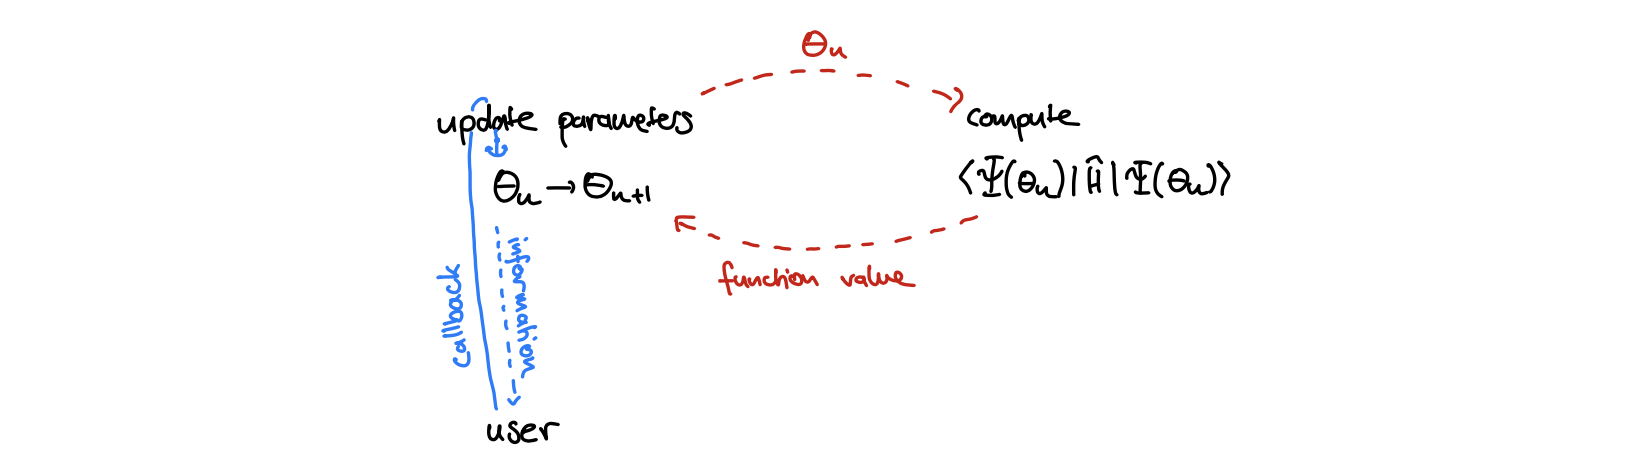

In [17]:
# 注意： GradientDescentクラスはQiskit 0.28.0でリリースされ、以下のようにしてインポートできます：
# from qiskit.algorithms.optimizers import GradientDescent
from qc_grader.gradient_descent import GradientDescent

gd_loss = []
def gd_callback(nfevs, x, fx, stepsize):
    gd_loss.append(fx)
    
gd = GradientDescent(maxiter=300, learning_rate=0.01, callback=gd_callback)

そして、最適化を開始し、損失をプロットします。

In [18]:
x_opt, fx_opt, nfevs = gd.optimize(initial_point.size,    # number of parameters
                                   evaluate_expectation,  # function to minimize
                                   gradient_function=evaluate_gradient,  # function to evaluate the gradient
                                   initial_point=initial_point)  # initial point

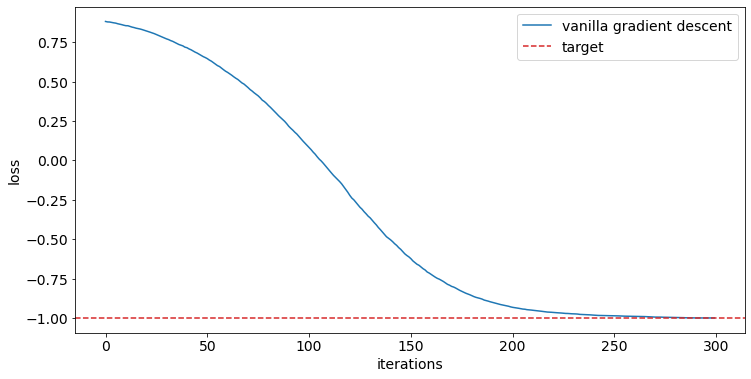

In [19]:
import matplotlib 
import matplotlib.pyplot as plt
matplotlib.rcParams['font.size'] = 14

plt.figure(figsize=(12, 6))
plt.plot(gd_loss, label='vanilla gradient descent')
plt.axhline(-1, ls='--', c='tab:red', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

### これはいつも動くのでしょうか？

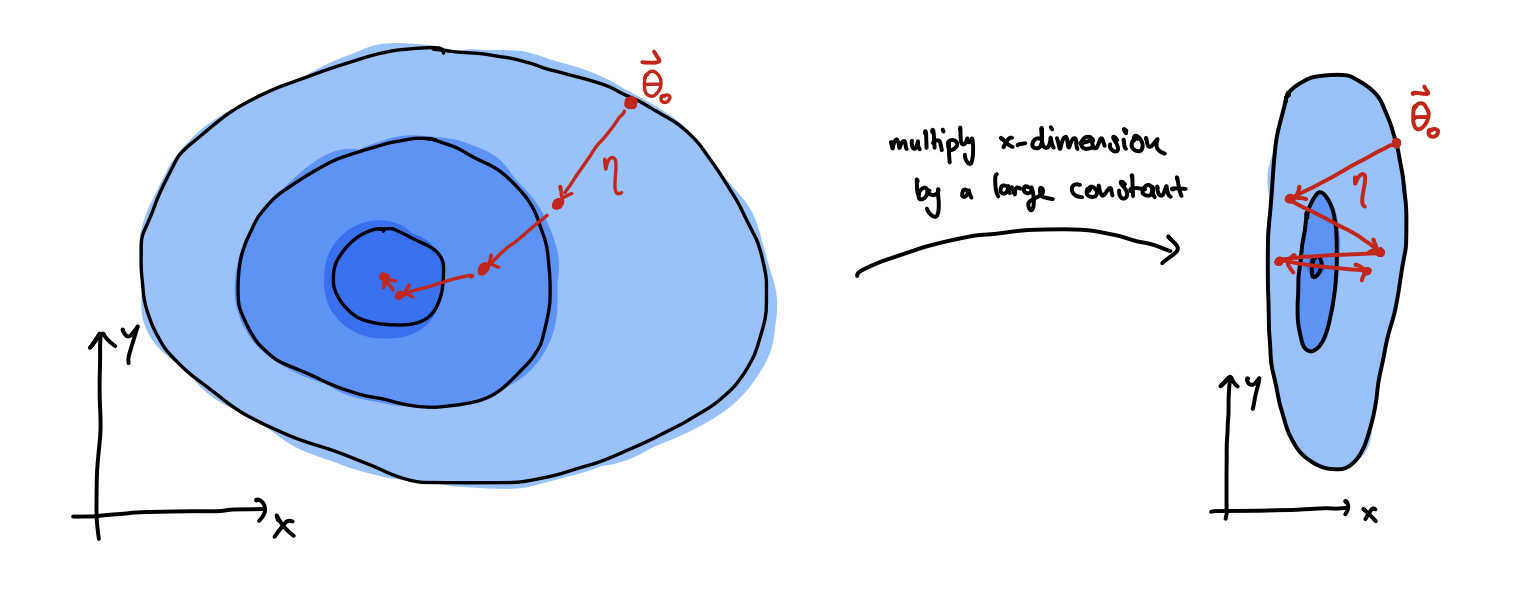

### 自然勾配

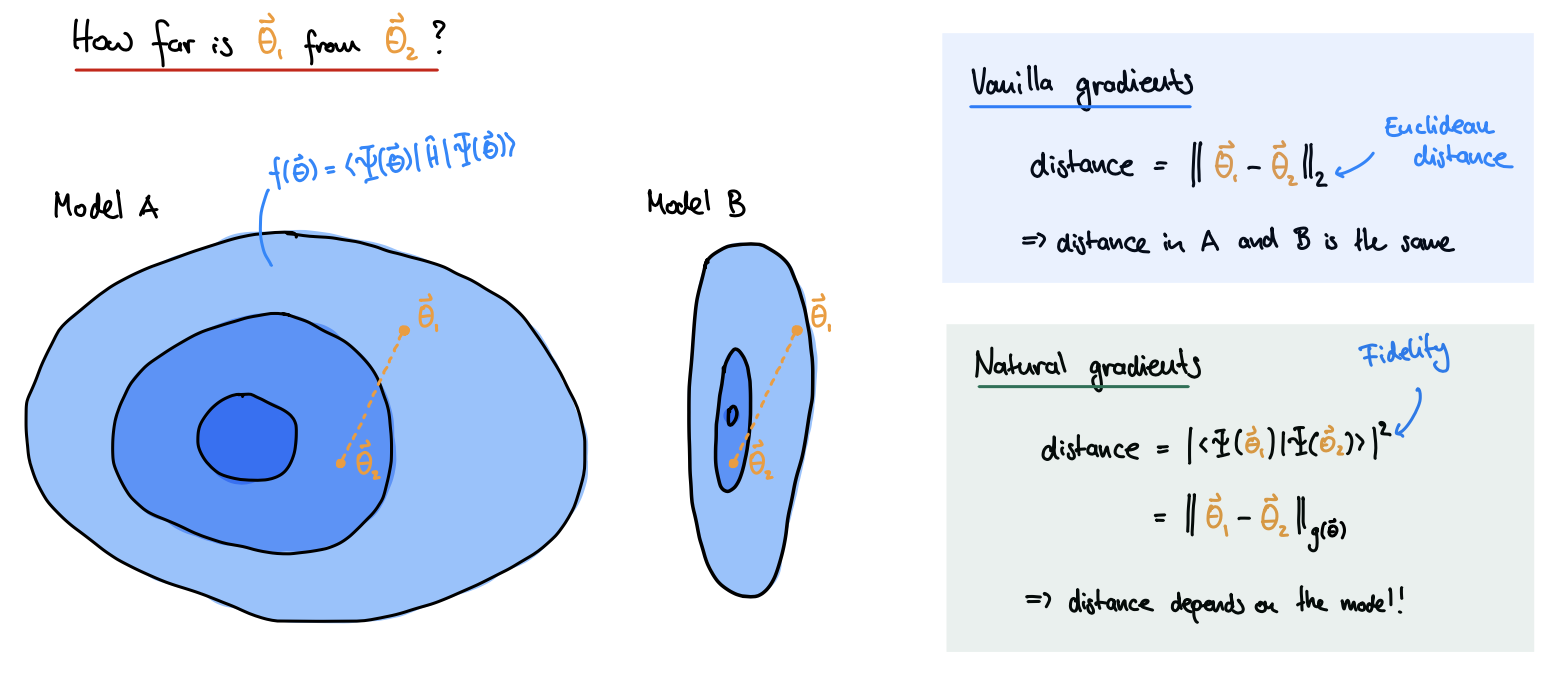

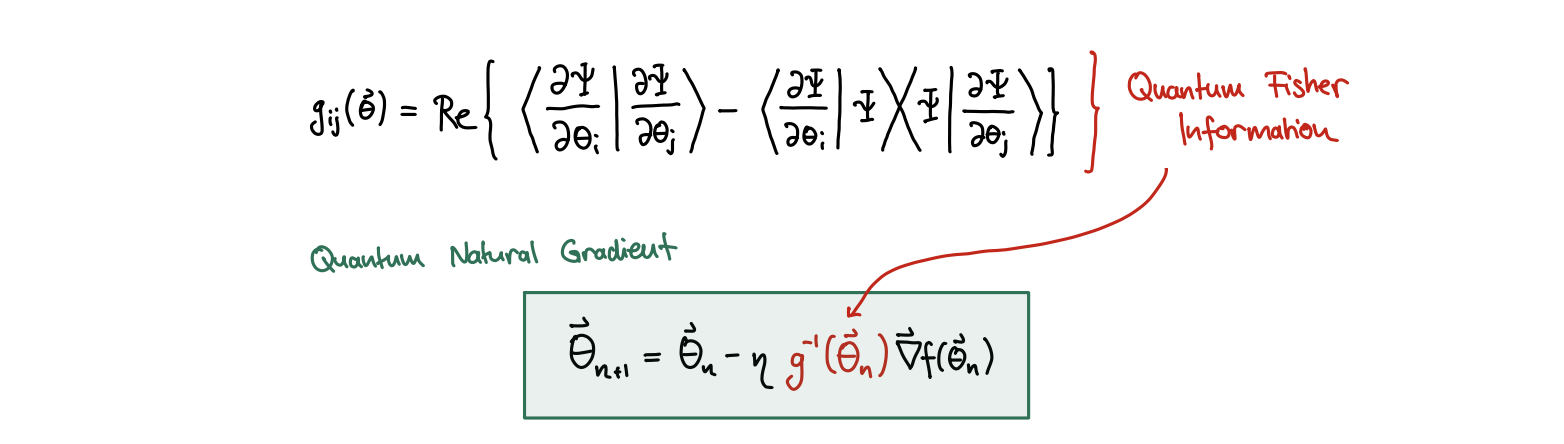

[Quantum Natural Gradient](https://arxiv.org/abs/1909.02108)

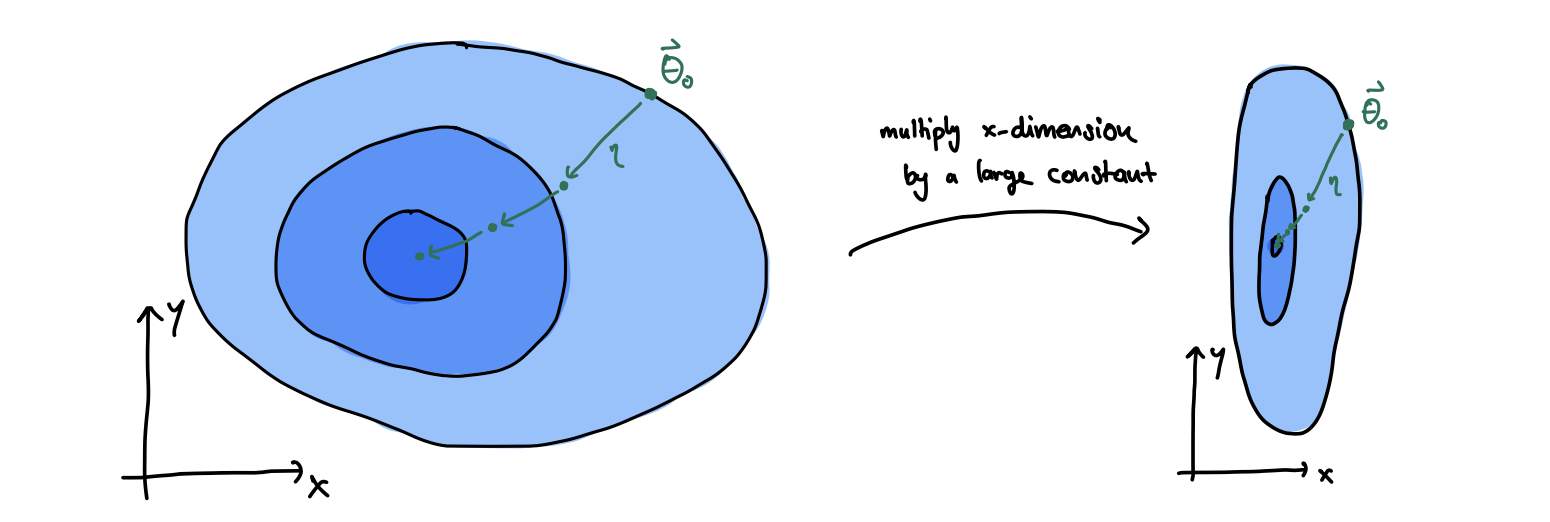

Qiskitでは、``Gradient``の代わりに``NaturalGradient``クラスを使うことで、自然勾配を評価することができます！

In [20]:
from qiskit.opflow import NaturalGradient

勾配を計算する関数と同様に、自然勾配を評価する関数を書くことができます。

In [21]:
expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(ansatz))  
natural_gradient = NaturalGradient(regularization='ridge').convert(expectation)
natural_gradient_in_pauli_basis = PauliExpectation().convert(natural_gradient)
sampler = CircuitSampler(q_instance, caching="all")

def evaluate_natural_gradient(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(natural_gradient, params=value_dict).eval()  
    return np.real(result)    

ご覧のように、実際に違いがあります。

In [22]:
print('Vanilla gradient:', evaluate_gradient(initial_point))
print('Natural gradient:', evaluate_natural_gradient(initial_point))

Vanilla gradient: [ 0.13989258 -0.35095215 -0.25402832 -0.22497559]
Natural gradient: [ 0.7158704  -0.86457346 -0.98086467 -0.33820315]


これが収束にどのような影響を与えるか見てみましょう。

In [23]:
qng_loss = []
def qng_callback(nfevs, x, fx, stepsize):
    qng_loss.append(fx)
    
qng = GradientDescent(maxiter=300, learning_rate=0.01, callback=qng_callback)

In [24]:
x_opt, fx_opt, nfevs = qng.optimize(initial_point.size, 
                                    evaluate_expectation, 
                                    gradient_function=evaluate_natural_gradient,
                                    initial_point=initial_point)

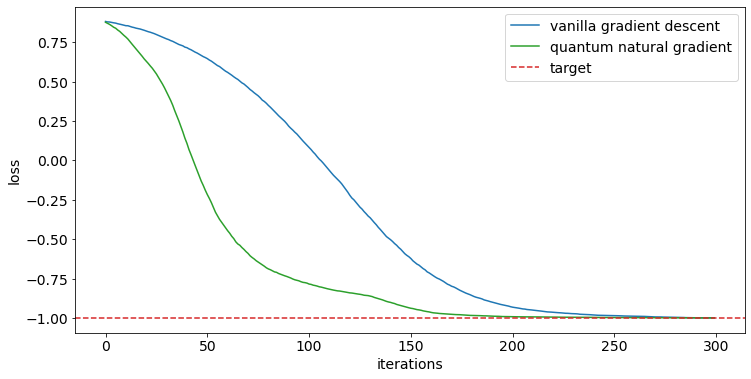

In [25]:
def plot_loss():
    plt.figure(figsize=(12, 6))
    plt.plot(gd_loss, 'tab:blue', label='vanilla gradient descent')
    plt.plot(qng_loss, 'tab:green', label='quantum natural gradient')
    plt.axhline(-1, c='tab:red', ls='--', label='target')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    
plot_loss()

これは素晴らしいことです。しかし、この勾配を評価するために必要な回路数を考えると、コストが高くなってしまいます。

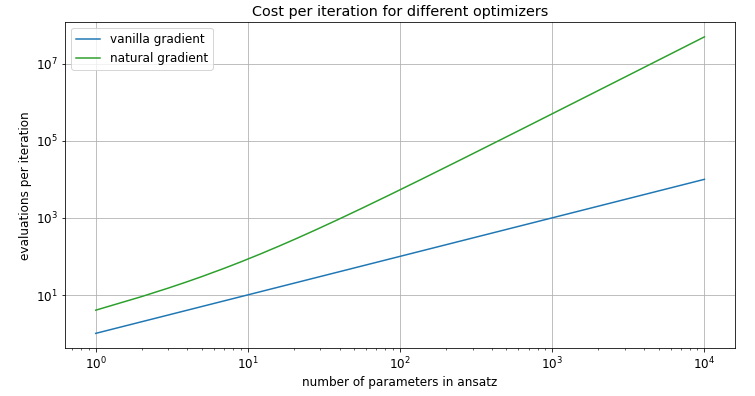

### 同時摂動による確率的近似法

アイデア: 勾配からサンプリングすることで、高価な勾配評価を避けます。正確な値は気にせず、収束だけを気にしているので、偏りのないのサンプリングは平均して同じようにうまくいくはずです。

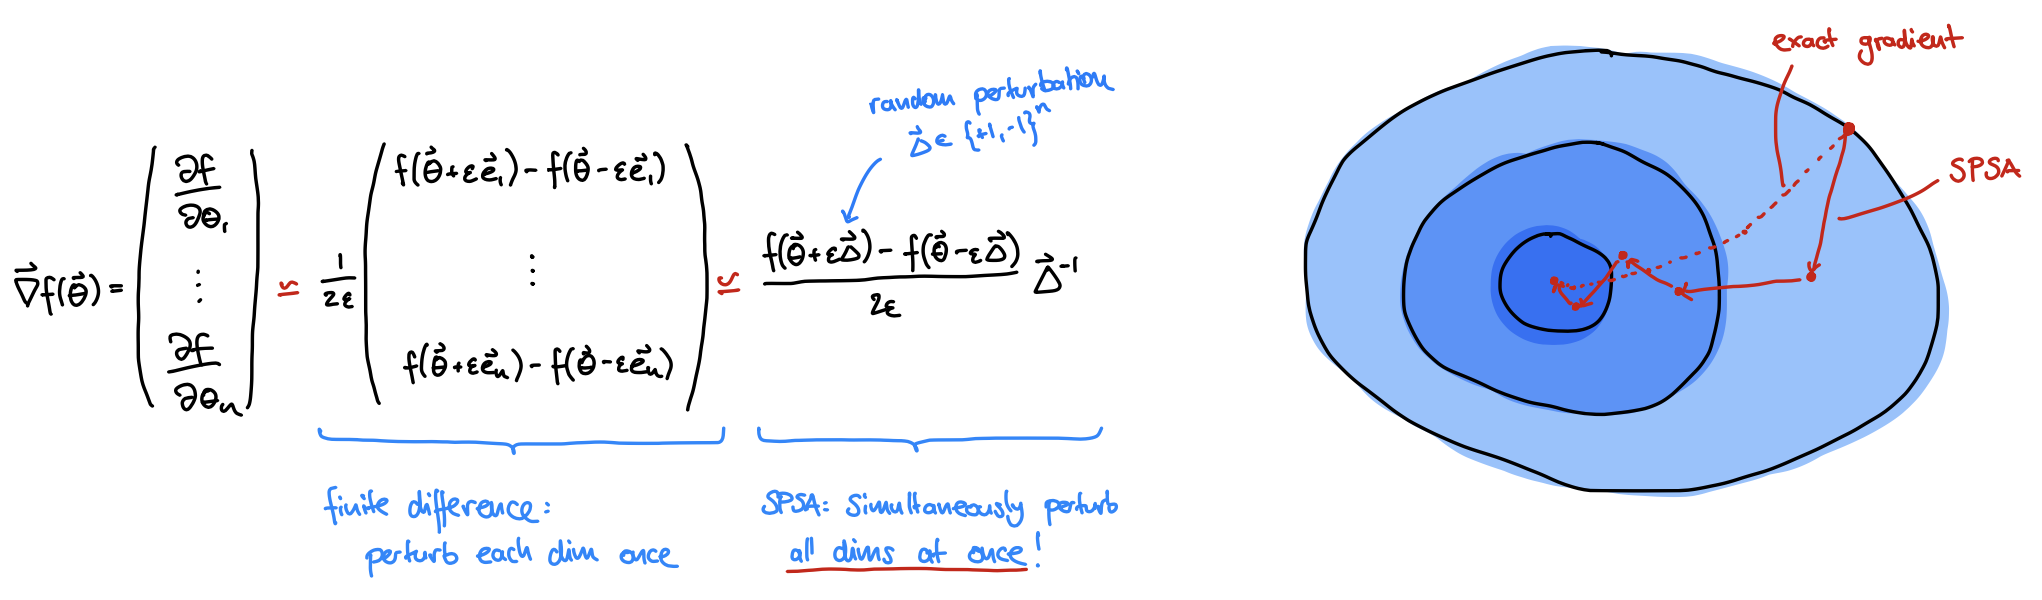

この最適化手法はSPSAと呼ばれています。その性能はどうでしょうか？

In [26]:
from qc_grader.spsa import SPSA

spsa_loss = []
def spsa_callback(nfev, x, fx, stepsize, accepted):
    spsa_loss.append(fx)

spsa = SPSA(maxiter=300, learning_rate=0.01, perturbation=0.01, callback=spsa_callback)

x_opt, fx_opt, nfevs = spsa.optimize(initial_point.size, 
                                     evaluate_expectation, 
                                     initial_point=initial_point)

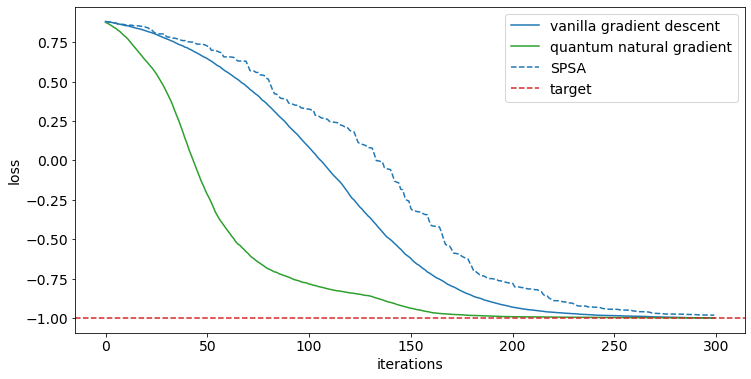

In [27]:
def plot_loss():
    plt.figure(figsize=(12, 6))
    plt.plot(gd_loss, 'tab:blue', label='vanilla gradient descent')
    plt.plot(qng_loss, 'tab:green', label='quantum natural gradient')
    plt.plot(spsa_loss, 'tab:blue', ls='--', label='SPSA')
    plt.axhline(-1, c='tab:red', ls='--', label='target')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    
plot_loss()

しかも、ほんのわずかなコストでした。

自然勾配も同じようにできるのでしょうか？

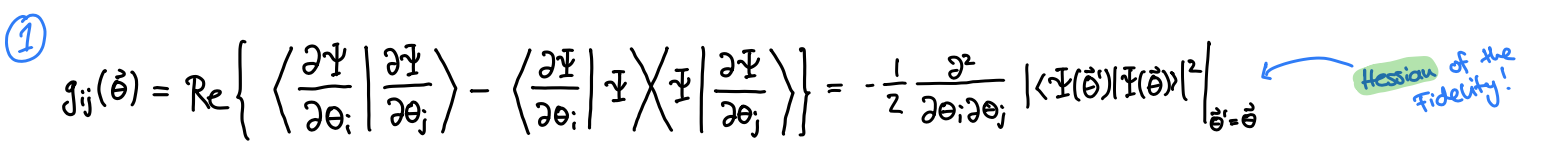

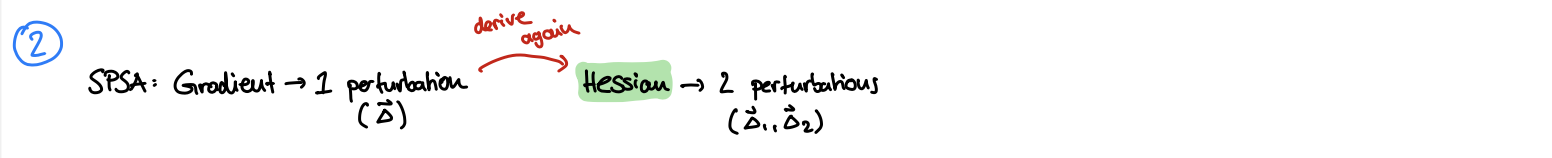

[Simultaneous Perturbation Stochastic Approximation of the Quantum Fisher Information](https://arxiv.org/abs/2103.09232)

その結果、なんと、できることがわかりました。

ここでは詳細を省略しますが、考え方としては、勾配からだけでなく、これを量子フィッシャー情報にまで拡大して、自然勾配にまで拡大することです。

In [28]:
# 注意: QNSPSAクラスはQiskit 0.28.0でリリースされ、以下のようにしてインポートできます：
# from qiskit.algorithms.optimizers import QNSPSA
from qc_grader.qnspsa import QNSPSA

qnspsa_loss = []
def qnspsa_callback(nfev, x, fx, stepsize, accepted):
    qnspsa_loss.append(fx)

fidelity = QNSPSA.get_fidelity(ansatz, q_instance, expectation=PauliExpectation())
qnspsa = QNSPSA(fidelity, maxiter=300, learning_rate=0.01, perturbation=0.01, callback=qnspsa_callback)

x_opt, fx_opt, nfevs = qnspsa.optimize(initial_point.size, 
                                       evaluate_expectation, 
                                       initial_point=initial_point)

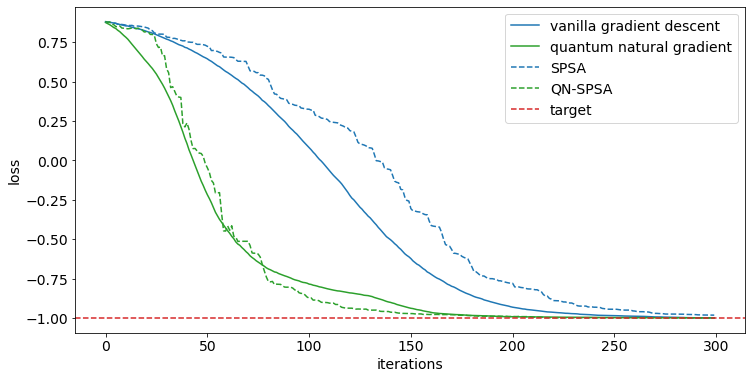

In [29]:
def plot_loss():
    plt.figure(figsize=(12, 6))
    plt.plot(gd_loss, 'tab:blue', label='vanilla gradient descent')
    plt.plot(qng_loss, 'tab:green', label='quantum natural gradient')
    plt.plot(spsa_loss, 'tab:blue', ls='--', label='SPSA')
    plt.plot(qnspsa_loss, 'tab:green', ls='--', label='QN-SPSA')
    plt.axhline(-1, c='tab:red', ls='--', label='target')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    
plot_loss()

コストはどのくらいでしょうか？

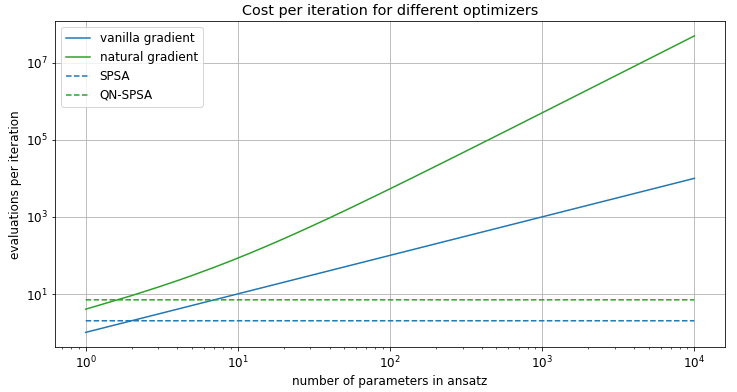

## 実践トレーニング


現在でも、勾配の評価は非常に高コストであり、また、どのような場合でもノイズの多い読み出しが行われるため、精度の向上はそれほど価値のあるものではありません。そのため、実際にはSPSAを使用することが多いです。収束性を高めるために、一定の学習率ではなく、指数関数的に減少する学習率を使用しています。

<div>
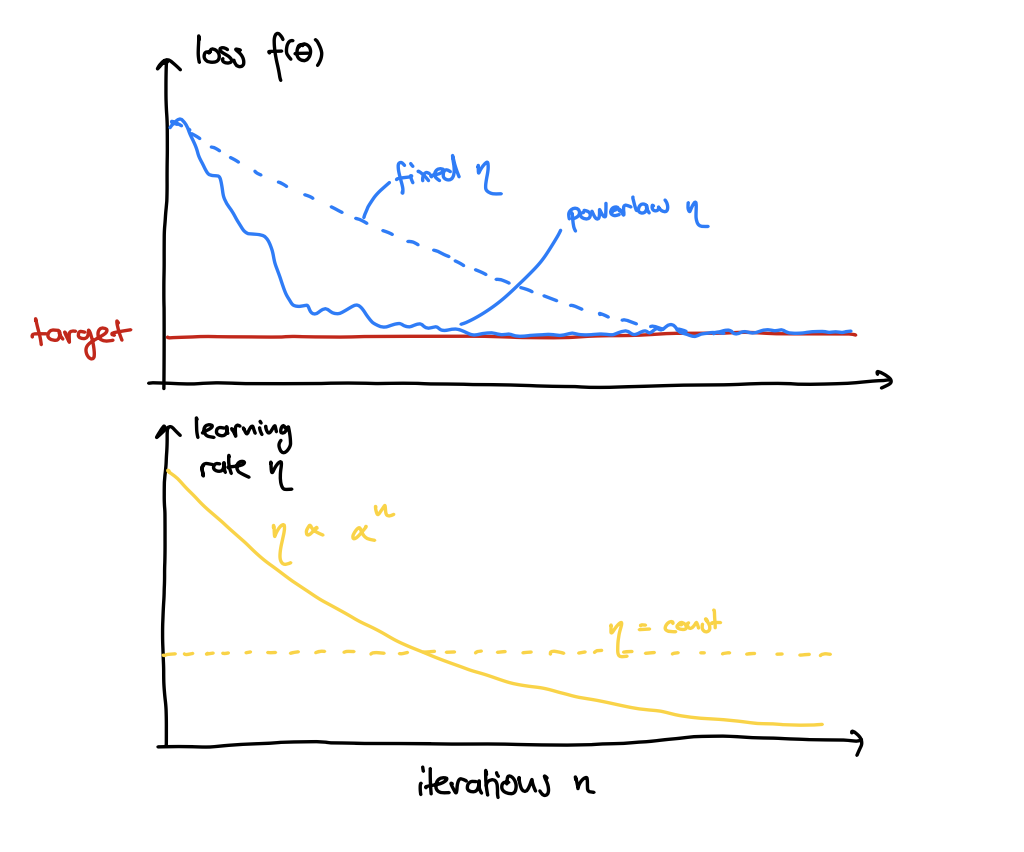
</div>

学習率が指定されていない場合、Qiskitは自動的に学習率をモデルにキャリブレーションしようとします。

In [30]:
autospsa_loss = []
def autospsa_callback(nfev, x, fx, stepsize, accepted):
    autospsa_loss.append(fx)

autospsa = SPSA(maxiter=300, learning_rate=None, perturbation=None, callback=autospsa_callback)

x_opt, fx_opt, nfevs = autospsa.optimize(initial_point.size, 
                                         evaluate_expectation, 
                                         initial_point=initial_point)

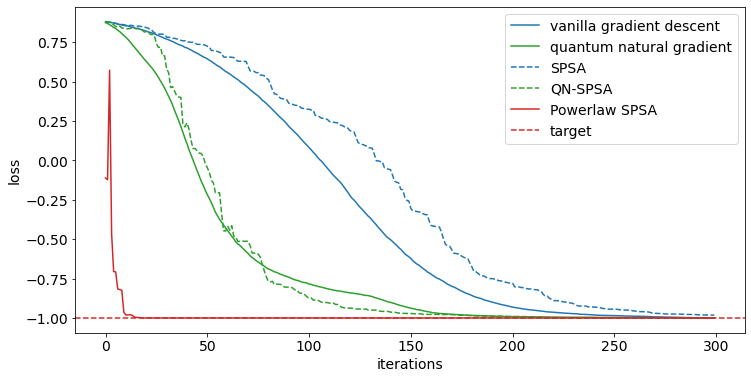

In [31]:
def plot_loss():
    plt.figure(figsize=(12, 6))
    plt.plot(gd_loss, 'tab:blue', label='vanilla gradient descent')
    plt.plot(qng_loss, 'tab:green', label='quantum natural gradient')
    plt.plot(spsa_loss, 'tab:blue', ls='--', label='SPSA')
    plt.plot(qnspsa_loss, 'tab:green', ls='--', label='QN-SPSA')
    plt.plot(autospsa_loss, 'tab:red', label='Powerlaw SPSA')
    plt.axhline(-1, c='tab:red', ls='--', label='target')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    
plot_loss()

**_新しい損失関数の学習_**

_この演習では、前回とは異なる損失関数を訓練します。3つのスピンを持つ線形鎖の横磁場イジングハミルトニアン_

$$
    \hat H = -Z_0 Z_1 - Z_1 Z_2 - X_0 - X_1 - X_2
$$
_あるいは、すべての操作を略さずに表記すると_
$$
    \hat H = -Z \otimes Z \otimes I - I \otimes Z \otimes Z - X \otimes I \otimes I - I \otimes X \otimes I - I \otimes I \otimes X.
$$

_Exercise 3: Opflowの演算子でハミルトニアンを定義してください。 テンソルの塊には必ず括弧をつけてください。, 例えば.  $X \otimes X + Z \otimes I$は``(X ^ X) + (Z ^ I)`` となるようにしてください_

In [ ]:
H_tfi = # TODO 

In [ ]:
from qc_grader import grade_lab4_ex3

# grade関数はハミルトニアンを期待していることに注意してください
grade_lab4_ex3(H_tfi)

_Exercise 4: 今は複素数の振幅を気にしているので、試行状態（Ansatz）として ``EfficientSU2`` 変分形式を使用します。横磁場イジングハミルトニアンのエネルギーを評価する ``evaluate_tfi`` 関数を使って、 ``SPSA`` で最適なパラメータを見つけます。_

In [ ]:
from qiskit.circuit.library import EfficientSU2

efficient_su2 = EfficientSU2(3, entanglement="linear", reps=2)
tfi_sampler = CircuitSampler(q_instance)

def evaluate_tfi(parameters):
    exp = StateFn(H_tfi, is_measurement=True).compose(StateFn(efficient_su2))  
    value_dict = dict(zip(efficient_su2.parameters, parameters))
    result = tfi_sampler.convert(PauliExpectation().convert(exp), params=value_dict).eval()  
    return np.real(result)   

_このセルでは、SPSAオプティマイザを使って最小値を求めます。_

_ヒント：（学習率と摂動を指定しないことで）自動キャリブレーションを使用し、300回反復すると、最小値に十分近づきます。_

In [ ]:
# ターゲットとなるエネルギー
tfi_target = -3.4939592074349326

# 再現性の初期値
tfi_init = np.array([0.95667807, 0.06192812, 0.47615196, 0.83809827, 0.89022282,
                     0.27140831, 0.9540853 , 0.41374024, 0.92595507, 0.76150126,
                     0.8701938 , 0.05096063, 0.25476016, 0.71807858, 0.85661325,
                     0.48311132, 0.43623886, 0.6371297 ])

tfi_result = # TODO SPSAによる最適化（自動キャリブレーションで300回反復すれば問題なし）
tfi_minimum = tfi_result[1]

In [ ]:
print("Error:", np.abs(tfi_result[1] - tfi_target))

In [ ]:
from qc_grader import grade_lab4_ex4

# grade関数は浮動小数点を期待していることに注意してください
grade_lab4_ex4(tfi_minimum)

## VQC/QNNsではどのように使えるのでしょうか？

<div>
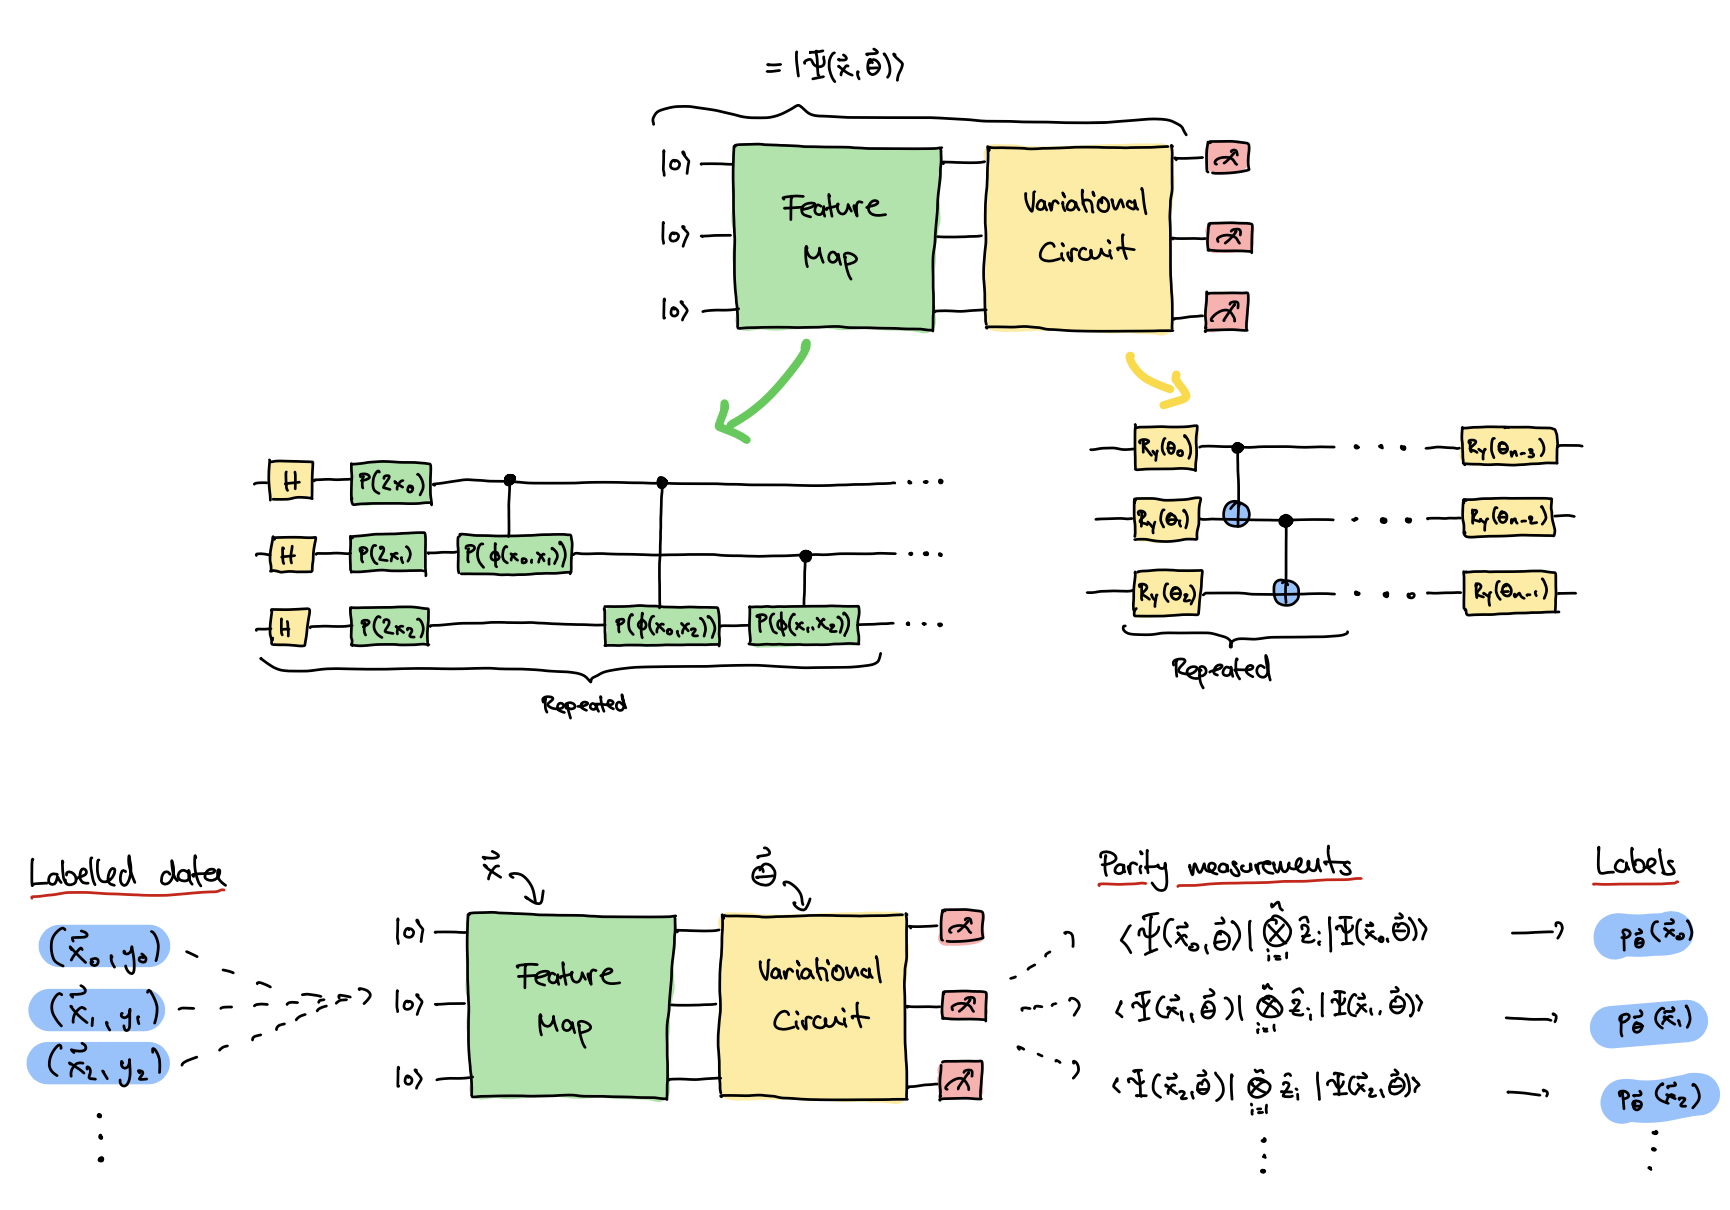
</div>

### データ生成

QiskitのMLパッケージで提供されている人工的なデータセットを使っています。他にもIrisやWineなどのデータセットがありますが、ここではデータをプロットできるようにシンプルな2次元のデータにします。

In [32]:
from qiskit_machine_learning.datasets import ad_hoc_data

training_features, training_labels, test_features, test_labels = ad_hoc_data(
    training_size=20, test_size=10, n=2, one_hot=False, gap=0.5
)

# トレーニングラベルは{0,1}ですが、クラスラベルとして{-1,1}を使用します。
training_labels = 2 * training_labels - 1
test_labels = 2 * test_labels - 1

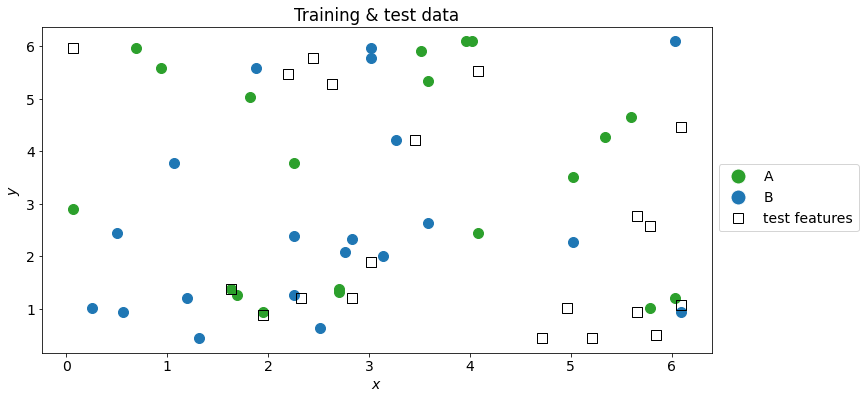

In [33]:
def plot_sampled_data():
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12,6))

    for feature, label in zip(training_features, training_labels):
        marker = 'o' 
        color = 'tab:green' if label == -1 else 'tab:blue'
        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    for feature, label in zip(test_features, test_labels):
        marker = 's' 
        plt.scatter(feature[0], feature[1], marker=marker, s=100, facecolor='none', edgecolor='k')
    
    legend_elements = [
        Line2D([0], [0], marker='o', c='w', mfc='tab:green', label='A', ms=15),
        Line2D([0], [0], marker='o', c='w', mfc='tab:blue', label='B', ms=15),
        Line2D([0], [0], marker='s', c='w', mfc='none', mec='k', label='test features', ms=10)
    ]

    plt.legend(handles=legend_elements, bbox_to_anchor=(1, 0.6))
    
    plt.title('Training & test data')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    
plot_sampled_data()

### 変分型量子分類器の構築

必要な構成要素を手に入れよう。

* データをエンコードする特徴量マップ
* 学習するための試行状態（Ansatz）
* 評価するための観測量


ここでは、回路ライブラリの標準的な特徴量マップを使用します。

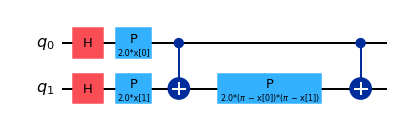

In [34]:
from qiskit.circuit.library import ZZFeatureMap

dim = 2
feature_map = ZZFeatureMap(dim, reps=1)  # シンプルにいきましょう！
feature_map.draw('mpl', style='iqx')

複素数の振幅は気にしないので、実数の振幅だけの試行状態（Ansatz）を使ってみましょう。

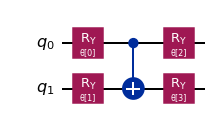

In [35]:
ansatz = RealAmplitudes(num_qubits=dim, entanglement='linear', reps=1)  # ここでもシンプルに！
ansatz.draw('mpl', style='iqx')

この回路をまとめると

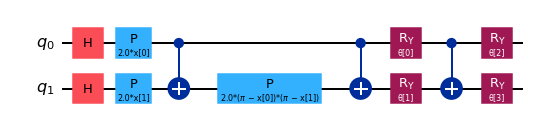

In [36]:
circuit = feature_map.compose(ansatz)
circuit.draw('mpl', style='iqx')

期待値のためのグローバルな$\bigotimes_{i} \hat Z_i$演算子を使います。

In [37]:
hamiltonian = Z ^ Z  # グローバルZ演算子

## データの分類

全てのパーツを理解したところで、いよいよデータを分類します。そのためにQiskitのMLパッケージを使用しており、回路と期待値を記述するための ``OpflowQNN`` クラスと、学習のための ``NeuralNetworkClassifier`` を使用しています。

まず、バニラの勾配降下法を行います。

In [38]:
gd_qnn_loss = []
def gd_qnn_callback(*args):
    gd_qnn_loss.append(args[2])
    
gd = GradientDescent(maxiter=100, learning_rate=0.01, callback=gd_qnn_callback)

In [39]:
from qiskit_machine_learning.neural_networks import OpflowQNN

qnn_expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(circuit)

qnn = OpflowQNN(qnn_expectation, 
                input_params=list(feature_map.parameters), 
                weight_params=list(ansatz.parameters),
                exp_val=PauliExpectation(),
                gradient=Gradient(),  # <-- パラメーターシフト勾配
                quantum_instance=q_instance)

ここで、QNN、損失、オプティマイザーを含む分類器を定義します。

In [40]:
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
#initial_point = np.array([0.2, 0.1, 0.3, 0.4])
classifier = NeuralNetworkClassifier(qnn, optimizer=gd)

... そして、学習！

In [41]:
classifier.fit(training_features, training_labels);

test_featureの新しいラベルを予測するには、 ``predict`` メソッドを使用します。

In [42]:
predicted = classifier.predict(test_features)

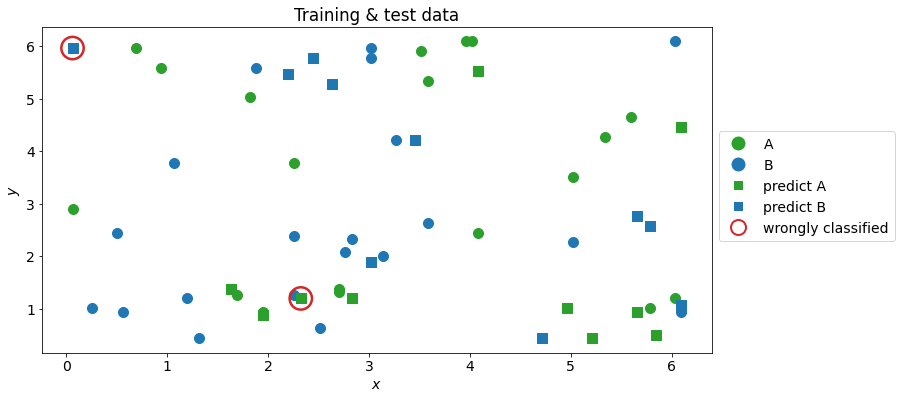

In [43]:
def plot_predicted():
    from matplotlib.lines import Line2D
    plt.figure(figsize=(12, 6))

    for feature, label in zip(training_features, training_labels):
        marker = 'o' 
        color = 'tab:green' if label == -1 else 'tab:blue'
        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    for feature, label, pred in zip(test_features, test_labels, predicted):
        marker = 's' 
        color = 'tab:green' if pred == -1 else 'tab:blue'
        if label != pred:  # 間違った分類をマーク
            plt.scatter(feature[0], feature[1], marker='o', s=500, linewidths=2.5,
                        facecolor='none', edgecolor='tab:red')

        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    legend_elements = [
        Line2D([0], [0], marker='o', c='w', mfc='tab:green', label='A', ms=15),
        Line2D([0], [0], marker='o', c='w', mfc='tab:blue', label='B', ms=15),
        Line2D([0], [0], marker='s', c='w', mfc='tab:green', label='predict A', ms=10),
        Line2D([0], [0], marker='s', c='w', mfc='tab:blue', label='predict B', ms=10),
        Line2D([0], [0], marker='o', c='w', mfc='none', mec='tab:red', label='wrongly classified', mew=2, ms=15)
    ]

    plt.legend(handles=legend_elements, bbox_to_anchor=(1, 0.7))
    
    plt.title('Training & test data')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    
plot_predicted()

また、自然勾配の使い方がわかったので、``Gradient``を``NaturalGradient``に置き換えることで、自然勾配降下法によるQNNの学習が可能になります。

In [44]:
qng_qnn_loss = []
def qng_qnn_callback(*args):
    qng_qnn_loss.append(args[2])
    
gd = GradientDescent(maxiter=100, learning_rate=0.01, callback=qng_qnn_callback)

In [45]:
qnn = OpflowQNN(qnn_expectation, 
                input_params=list(feature_map.parameters), 
                weight_params=list(ansatz.parameters),
                gradient=NaturalGradient(regularization='ridge'),  # <-- 自然勾配を使っています!
                quantum_instance=q_instance)
classifier = NeuralNetworkClassifier(qnn, optimizer=gd)#, initial_point=initial_point)

In [46]:
classifier.fit(training_features, training_labels);

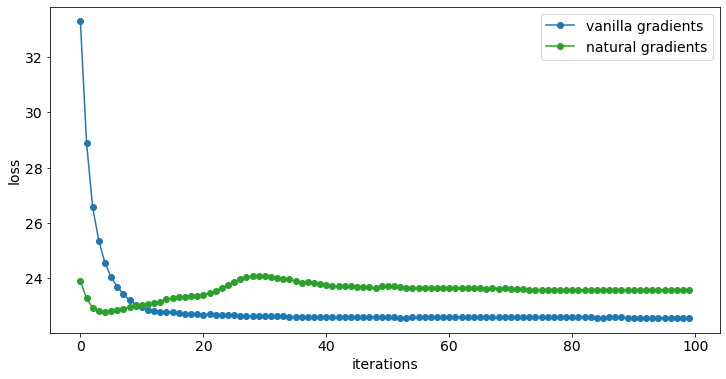

In [47]:
def plot_losses():

    plt.figure(figsize=(12, 6))
    plt.plot(gd_qnn_loss, 'tab:blue', marker='o', label='vanilla gradients')
    plt.plot(qng_qnn_loss, 'tab:green', marker='o', label='natural gradients')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.legend(loc='best')

plot_losses()

## 学習回路の限界

人生にタダで手に入るものはありません...それは、すべてのモデルに十分な大きさの勾配があることも含みます。

勾配を利用したトレーニングは、テストした小さなモデルではうまくいくことがわかりました。しかし、量子ビットの数を増やしても、同じことが期待できるのでしょうか？これを調べるために、異なるモデルサイズの勾配の分散を測定しました。考え方は簡単で、もし分散が非常に小さければ、パラメータを更新するのに十分な情報が無いということになります。

### 指数関数的勾配消失 (不毛な台地：Barren plateaus)

[Barren plateaus in quantum neural network training landscapes](https://arxiv.org/abs/1803.11173)

[Cost Function Dependent Barren Plateaus in Shallow Parametrized Quantum Circuits](http://arxiv-export-lb.library.cornell.edu/pdf/2001.00550)

勾配の中から好きな例を選び、量子ビット数やレイヤー数を増やした場合にどうなるかを見てみましょう。

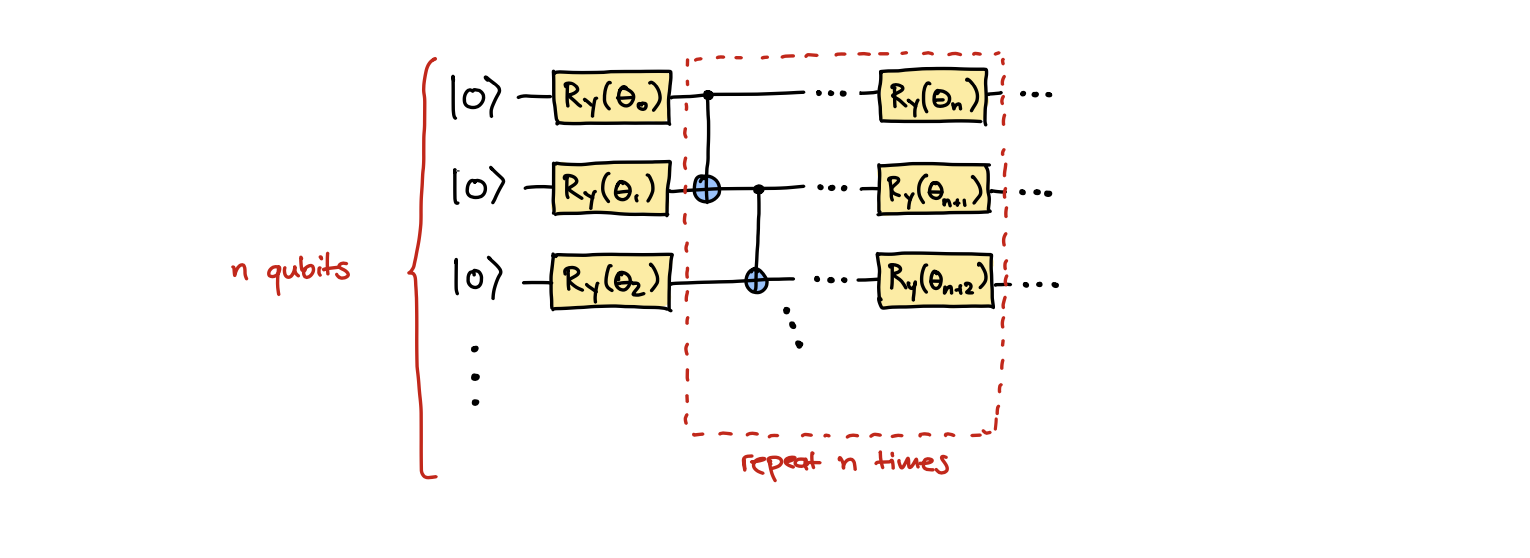

In [48]:
from qiskit.opflow import I

def sample_gradients(num_qubits, reps, local=False):
    """``num_qubits`` の量子ビットと ``reps`` の繰り返しに対して、我々のモデルの勾配をサンプリングします。
    
    ランダムなパラメータで100回サンプリングし、最初のRY回転ゲートの勾配を計算します。
    """
    index = num_qubits - 1

    # これをローカルの演算子と交換して、同じように観察することもできます。
    if local:
        operator = Z ^ Z ^ (I ^ (num_qubits - 2))
    else:
        operator = Z ^ num_qubits
    
    # 実質的な振幅Ansatz
    ansatz = RealAmplitudes(num_qubits, entanglement='linear', reps=reps)

    # 異なる値で評価したい勾配を構築します。
    expectation = StateFn(operator, is_measurement=True).compose(StateFn(ansatz))
    grad = Gradient().convert(expectation, params=ansatz.parameters[index])
    
    # 100種類のランダムなパラメータ値で評価
    num_points = 100
    grads = []
    for _ in range(num_points):
        # 点は0からπの間から一様に選ばれます。
        point = np.random.uniform(0, np.pi, ansatz.num_parameters)
        value_dict = dict(zip(ansatz.parameters, point))
        grads.append(sampler.convert(grad, value_dict).eval())
        
    return grads

2量子ビットから12量子ビットまでプロットしてみましょう。

In [49]:
num_qubits = list(range(2, 13))
reps = num_qubits  # 層の数＝量子ビットの数
gradients = [sample_gradients(n, r) for n, r in zip(num_qubits, reps)]  

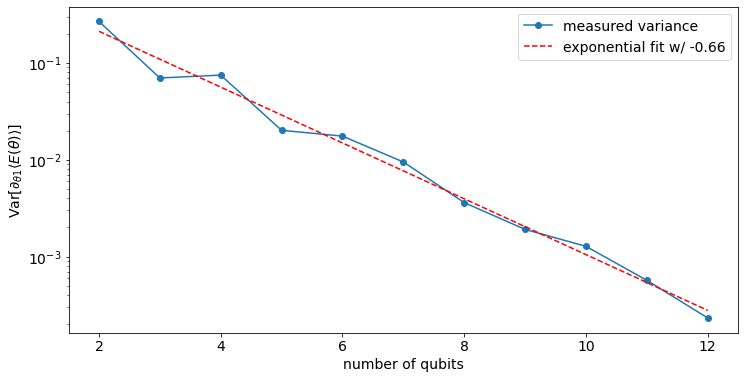

In [51]:
fit = np.polyfit(num_qubits, np.log(np.var(gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-', label='measured variance')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

なんと、分散が指数関数的に減少しているではありませんか。つまり、勾配に含まれる情報がどんどん少なくなり、モデルの学習に苦労することになります。これは、不毛な台地（ _Barren plateau_ ）問題または指数関数的勾配消失（ _exponentially vanishing gradients_ ）として知られています。

**_Exploratory Exercise: 自然勾配は勾配消失問題の影響を受けるか?_**

_標準的な勾配の代わりに自然勾配でBarren plateau plotを繰り返します。このために，その勾配の代わりに自然勾配を計算する新しい関数 ``sample_natural_gradients`` を書きます。_

In [ ]:
from qiskit.opflow import NaturalGradient

def sample_natural_gradients(num_qubits, reps):
    index = num_qubits - 1

    operator = Z ^ num_qubits
    
    ansatz = RealAmplitudes(num_qubits, entanglement='linear', reps=reps)

    expectation = StateFn(operator, is_measurement=True).compose(StateFn(ansatz))
    grad = # TODO: grad``は、添字 ``index`` におけるパラメータの自然な勾配でなければならない。
    # Hint: ``sample_gradients`` 関数をチェックしてみてください、これもほとんど同じです。
    grad = NaturalGradient().convert(expectation, params=ansatz.parameters[index])
    
    num_points = 100
    grads = []
    for _ in range(num_points):
        point = np.random.uniform(0, np.pi, ansatz.num_parameters)
        value_dict = dict(zip(ansatz.parameters, point))
        grads.append(sampler.convert(grad, value_dict).eval())
    return grads

_今度は、勾配の分散を確認するために実験を繰り返します（このセルの実行には時間がかかります！）。_

In [ ]:
num_qubits = list(range(2, 13))
reps = num_qubits  # 層の数＝量子ビットの数
natural_gradients = [sample_natural_gradients(n, r) for n, r in zip(num_qubits, reps)]  

_その結果をプロットします。何が見えてきましたか？_

In [ ]:
fit = np.polyfit(num_qubits, np.log(np.var(natural_gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-', label='vanilla gradients')
plt.semilogy(num_qubits, np.var(natural_gradients, axis=1), 's-', label='natural gradients')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {float(fit[0]):.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

### 回路の短縮化については？

この「不毛な台地」について、私たちは何かできることがあるのでしょうか？現在の研究ではホットな話題であり、不毛な台地を緩和するための提案もなされています。

ここでは、グローバルおよびローカルなコスト関数と試行状態（Ansatz）の深さが不毛な台地にどのような影響を与えるかを見てみましょう。

In [52]:
num_qubits = list(range(2, 13))
fixed_depth_global_gradients = [sample_gradients(n, 1) for n in num_qubits]  

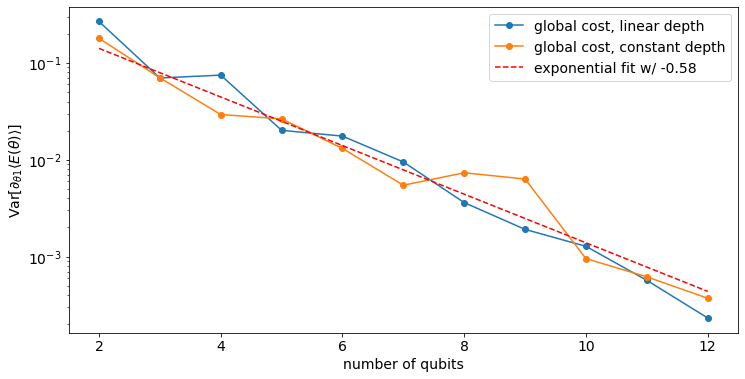

In [53]:
fit = np.polyfit(num_qubits, np.log(np.var(fixed_depth_global_gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-', label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1), 'o-', label='global cost, constant depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

### また、_local_ の演算子を使った場合はどうでしょうか？

In [54]:
num_qubits = list(range(2, 13))
linear_depth_local_gradients = [sample_gradients(n, n, local=True) for n in num_qubits]  

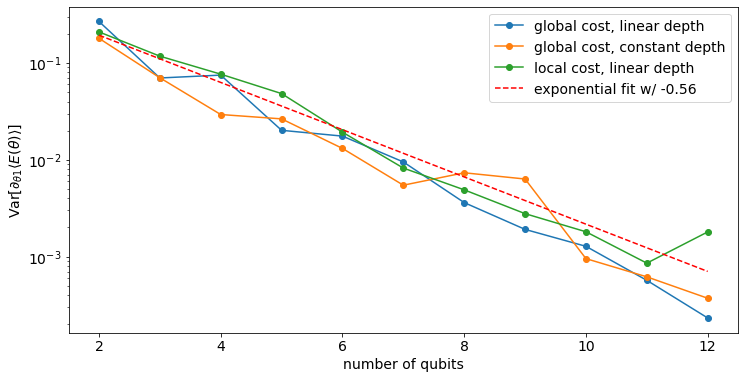

In [55]:
fit = np.polyfit(num_qubits, np.log(np.var(linear_depth_local_gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-', label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1), 'o-', label='global cost, constant depth')
plt.semilogy(num_qubits, np.var(linear_depth_local_gradients, axis=1), 'o-', label='local cost, linear depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

In [56]:
num_qubits = list(range(2, 13))
fixed_depth_local_gradients = [sample_gradients(n, 1, local=True) for n in num_qubits]  

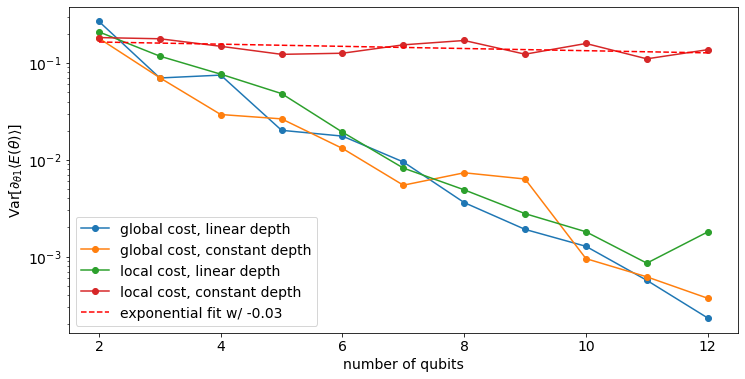

In [57]:
fit = np.polyfit(num_qubits, np.log(np.var(fixed_depth_local_gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-', label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1), 'o-', label='global cost, constant depth')
plt.semilogy(num_qubits, np.var(linear_depth_local_gradients, axis=1), 'o-', label='local cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_local_gradients, axis=1), 'o-', label='local cost, constant depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

### 層別学習

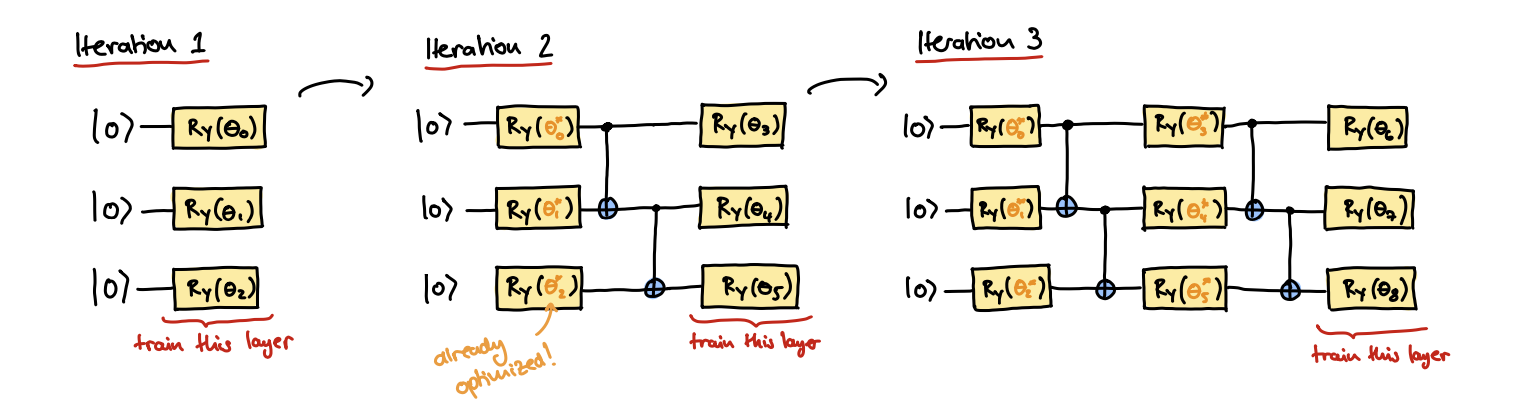

In [58]:
num_qubits = 6
operator = Z ^ Z ^ (I ^ (num_qubits - 4))

def minimize(circuit, optimizer):
    initial_point = np.random.random(circuit.num_parameters)
    
    exp = StateFn(operator, is_measurement=True) @ StateFn(circuit)
    grad = Gradient().convert(exp)
    
    # pauli basis
    exp = PauliExpectation().convert(exp)
    grad = PauliExpectation().convert(grad)

    sampler = CircuitSampler(q_instance, caching="all")
    
    def loss(x):
        values_dict = dict(zip(circuit.parameters, x))
        return np.real(sampler.convert(exp, values_dict).eval())
    
    def gradient(x):
        values_dict = dict(zip(circuit.parameters, x))
        return np.real(sampler.convert(grad, values_dict).eval())

    return optimizer.optimize(circuit.num_parameters, loss, gradient, initial_point=initial_point)

便利な機能:Qiskitの試行状態（Ansatz）回路は可変的にできます!

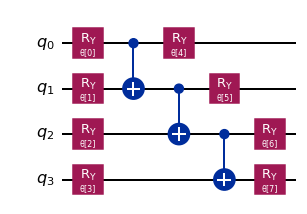

In [59]:
circuit = RealAmplitudes(4, reps=1, entanglement='linear')
circuit.draw('mpl', style='iqx')

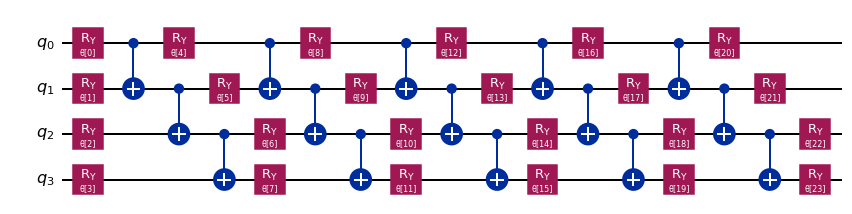

In [60]:
circuit.reps = 5
circuit.draw('mpl', style='iqx')

In [64]:
def layerwise_training(ansatz, max_num_layers, optimizer):
    optimal_parameters = []
    fopt = None
    for reps in range(1, max_num_layers):
        ansatz.reps = reps
        
        # 既に最適化されたパラメータの結合
        values_dict = dict(zip(ansatz.parameters, optimal_parameters))
        partially_bound = ansatz.bind_parameters(values_dict)
        
        xopt, fopt, _ = minimize(partially_bound, optimizer)
        print('Circuit depth:', ansatz.depth(), 'best value:', fopt)
        optimal_parameters += list(xopt)
    
    return fopt, optimal_parameters

In [65]:
ansatz = RealAmplitudes(4, entanglement='linear')
optimizer = GradientDescent(maxiter=50)

In [66]:
np.random.seed(12)
fopt, optimal_parameters = layerwise_training(ansatz, 4, optimizer)

Circuit depth: 5 best value: 0.2421875
Circuit depth: 8 best value: -0.14428710937499992
Circuit depth: 11 best value: -0.513427734375


## まとめ

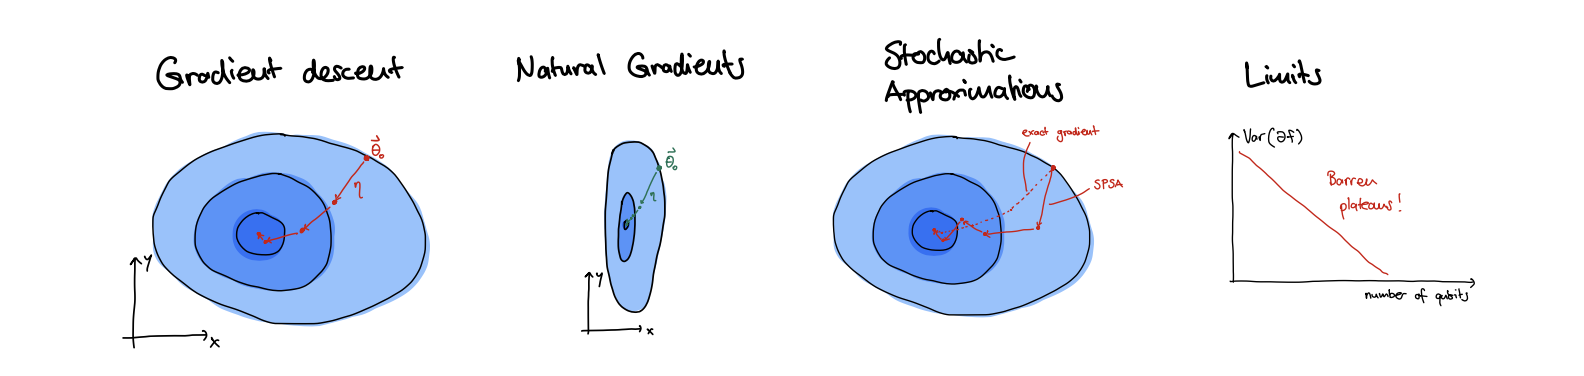